# Projeto Integrado de Classificação Supervisionada
Disciplina: Inteligência Artificial — Prof. Dr. Fabiano Menegidio  
Autores: ALYSON RODRIGO MIGUEL PEREIRA
Instituição: UMC  
Resumo: Experimentos com XGBoost, SVM e RandomForest no dataset Titanic; e escolha do HistGradientBoosting para o dataset Breast Cancer, com comparações.  


In [ ]:
# instala pacotes
!pip install -q xgboost shap

# imports básicos
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split, StratifiedKFold, RandomizedSearchCV, GridSearchCV, cross_validate
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, confusion_matrix, roc_curve, precision_recall_curve, auc

from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.svm import SVC
import xgboost as xgb
import joblib

# deixar reproduzível
RANDOM_STATE = 42

# criar pastas
os.makedirs('img', exist_ok=True)
os.makedirs('doc', exist_ok=True)
os.makedirs('models', exist_ok=True)

print('Imports ok, pastas criadas')

Imports ok, pastas criadas


In [ ]:
import seaborn as sns
raw = sns.load_dataset('titanic')
print('shape:', raw.shape)
raw.head()

shape: (891, 15)


,survived,pclass,sex,age,sibsp,parch,fare,embarked,class,who,adult_male,deck,embark_town,alive,alone
0,0,3,male,22.0,1,0,7.2500,S,Third,man,True,NaN,Southampton,no,False
1,1,1,female,38.0,1,0,71.2833,C,First,woman,False,C,Cherbourg,yes,False
2,1,3,female,26.0,0,0,7.9250,S,Third,woman,False,NaN,Southampton,yes,True
3,1,1,female,35.0,1,0,53.1000,S,First,woman,False,C,Southampton,yes,False
4,0,3,male,35.0,0,0,8.0500,S,Third,man,True,NaN,Southampton,no,True


In [ ]:
# colunas sugeridas: pclass, sex, age, fare, sibsp, parch, embarked
df = raw[['pclass','sex','age','fare','sibsp','parch','embarked','survived']].copy()
# transformar pclass como string (categoria)
df['pclass'] = df['pclass'].astype(str)
df['embarked'] = df['embarked'].fillna('Missing')
df = df[df['survived'].notna()]

print('after cleaning shape:', df.shape)
df.sample(5)

after cleaning shape: (891, 8)


,pclass,sex,age,fare,sibsp,parch,embarked,survived
79,3,female,30.0,12.475,0,0,S,1
842,1,female,30.0,31.000,0,0,C,1
517,3,male,NaN,24.150,0,0,Q,0
208,3,female,16.0,7.750,0,0,Q,1
719,3,male,33.0,7.775,0,0,S,0


In [ ]:
X = df.drop('survived', axis=1)
y = df['survived'].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE)
print('train:', X_train.shape, 'test:', X_test.shape)

train: (712, 7) test: (179, 7)


In [ ]:
num_features = ['age','fare']
cat_features = ['sex','embarked','pclass']

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ohe', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

preprocessor = ColumnTransformer([
    ('num', num_pipeline, num_features),
    ('cat', cat_pipeline, cat_features)
])


In [ ]:
from scipy.stats import randint, uniform

# Pipelines com classifiers
pipe_xgb = Pipeline([('pre', preprocessor), ('clf', xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=RANDOM_STATE))])
pipe_svc = Pipeline([('pre', preprocessor), ('clf', SVC(probability=True, random_state=RANDOM_STATE))])
pipe_rf  = Pipeline([('pre', preprocessor), ('clf', RandomForestClassifier(random_state=RANDOM_STATE))])

# Distribuições
param_xgb = {
    'clf__n_estimators': randint(50,150),
    'clf__max_depth': randint(3,8),
    'clf__learning_rate': uniform(0.01,0.2)
}
param_svc = {
    'clf__C': uniform(0.1,5),
    'clf__gamma': ['scale','auto']
}
param_rf = {
    'clf__n_estimators': randint(50,150),
    'clf__max_depth': randint(3,15)
}

# função utilitária
def run_rs(pipe, params, Xtr, ytr, n_iter=15):
    skf = StratifiedKFold(n_splits=4, shuffle=True, random_state=RANDOM_STATE)
    rs = RandomizedSearchCV(pipe, params, n_iter=n_iter, cv=skf, scoring='roc_auc', n_jobs=-1, random_state=RANDOM_STATE, verbose=1)
    rs.fit(Xtr, ytr)
    return rs

print('Iniciando busca XGB (poucos iters)')
rs_xgb = run_rs(pipe_xgb, param_xgb, X_train, y_train, n_iter=20)
print('XGB done')

print('Iniciando busca SVC')
rs_svc = run_rs(pipe_svc, param_svc, X_train, y_train, n_iter=20)
print('SVC done')

print('Iniciando busca RF')
rs_rf = run_rs(pipe_rf, param_rf, X_train, y_train, n_iter=20)
print('RF done')

Iniciando busca XGB (poucos iters)
Fitting 4 folds for each of 20 candidates, totalling 80 fits


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:199: UserWarning: [03:01:08] WARNING: /workspace/src/learner.cc:790: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGB done
Iniciando busca SVC
Fitting 4 folds for each of 20 candidates, totalling 80 fits
SVC done
Iniciando busca RF
Fitting 4 folds for each of 20 candidates, totalling 80 fits
RF done


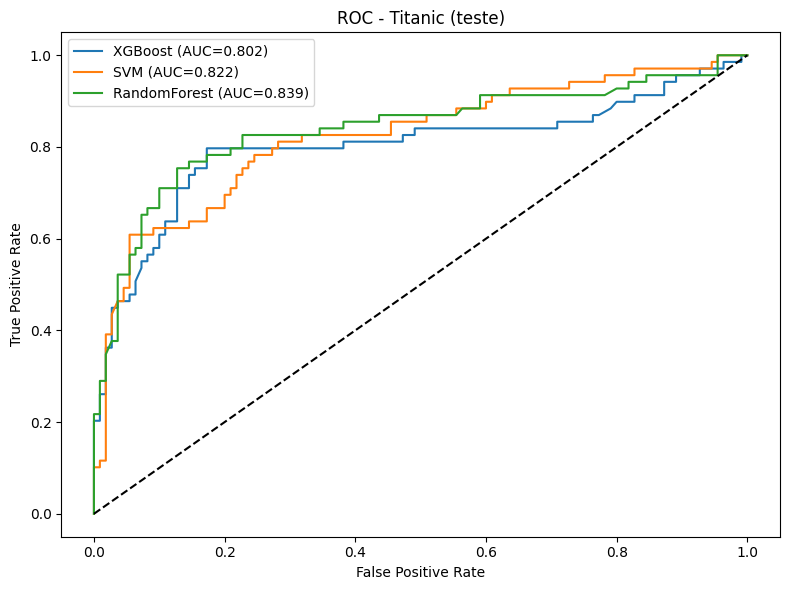

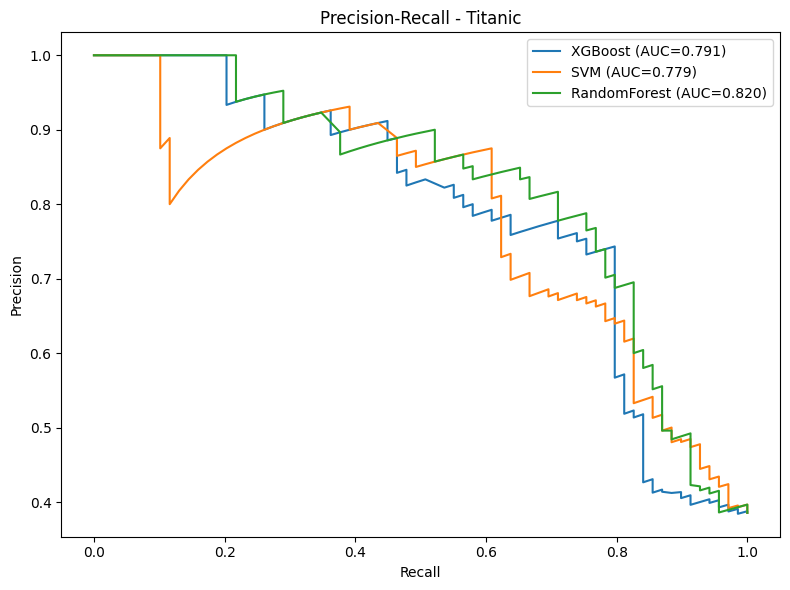

,model,roc_auc,accuracy,f1,cm
0,XGBoost,0.801647,0.804469,0.736842,"[[95, 15], [20, 49]]"
1,SVM,0.821871,0.798883,0.684211,"[[104, 6], [30, 39]]"
2,RandomForest,0.839328,0.810056,0.730159,"[[99, 11], [23, 46]]"


In [ ]:
best_models = {
    'XGBoost': rs_xgb.best_estimator_,
    'SVM': rs_svc.best_estimator_,
    'RandomForest': rs_rf.best_estimator_
}

results = []
plt.figure(figsize=(8,6))
for name, model in best_models.items():
    y_proba = model.predict_proba(X_test)[:,1]
    y_pred = model.predict(X_test)
    roc = roc_auc_score(y_test, y_proba)
    acc = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    results.append({'model':name,'roc_auc':roc,'accuracy':acc,'f1':f1,'cm':cm})
    fpr, tpr, _ = roc_curve(y_test, y_proba)
    plt.plot(fpr, tpr, label=f'{name} (AUC={roc:.3f})')

plt.plot([0,1],[0,1],'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC - Titanic (teste)')
plt.legend()
plt.tight_layout()
plt.savefig('img/titanic_roc.png')
plt.show()

# Precision-Recall
plt.figure(figsize=(8,6))
for name, model in best_models.items():
    y_proba = model.predict_proba(X_test)[:,1]
    precision, recall, _ = precision_recall_curve(y_test, y_proba)
    pr_auc = auc(recall, precision)
    plt.plot(recall, precision, label=f'{name} (AUC={pr_auc:.3f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall - Titanic')
plt.legend()
plt.tight_layout()
plt.savefig('img/titanic_pr.png')
plt.show()

pd.DataFrame(results)

In [ ]:
from sklearn.datasets import load_breast_cancer
data = load_breast_cancer()
Xbc = pd.DataFrame(data.data, columns=data.feature_names)
ybc = pd.Series(data.target, name='target')
print('X shape:', Xbc.shape)

display(Xbc.head())

X shape: (569, 30)


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [ ]:
from sklearn.feature_selection import SelectKBest, f_classif

num_pipeline_bc = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler()),
    ('select', SelectKBest(score_func=f_classif, k=12))
])

pipe_hgb = Pipeline([
    ('pre', num_pipeline_bc),
    ('clf', HistGradientBoostingClassifier(random_state=RANDOM_STATE))
])

param_grid_hgb = {
    'clf__learning_rate':[0.01, 0.1],
    'clf__max_iter':[100, 200]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
gs_hgb = GridSearchCV(pipe_hgb, param_grid_hgb, scoring='roc_auc', cv=cv, n_jobs=-1, verbose=1)
print('Treinando HGB (pouco tempo)')
gs_hgb.fit(Xbc, ybc)
print('best params:', gs_hgb.best_params_, 'best score:', gs_hgb.best_score_)

Treinando HGB (pouco tempo)
Fitting 5 folds for each of 4 candidates, totalling 20 fits
best params: {'clf__learning_rate': 0.01, 'clf__max_iter': 200} best score: 0.9855598166951755


In [ ]:
models = {
    'HGB': gs_hgb.best_estimator_,
    'XGBoost': Pipeline([('pre', num_pipeline_bc), ('clf', xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss'))]),
    'SVC': Pipeline([('pre', num_pipeline_bc), ('clf', SVC(probability=True))]),
    'RandomForest': Pipeline([('pre', num_pipeline_bc), ('clf', RandomForestClassifier())])
}

scoring = ['roc_auc','accuracy','f1']
summary = {}
for name, model in models.items():
    print('cv', name)
    cvres = cross_validate(model, Xbc, ybc, cv=cv, scoring=scoring, n_jobs=-1)
    summary[name] = {s: np.mean(cvres[f'test_{s}']) for s in scoring}

pd.DataFrame(summary).T

cv HGB
cv XGBoost
cv SVC
cv RandomForest


,roc_auc,accuracy,f1
HGB,0.985560,0.943798,0.955332
XGBoost,0.983338,0.949045,0.959838
SVC,0.988002,0.947306,0.958777
RandomForest,0.983099,0.938503,0.951436


worst concave points    0.017070
worst perimeter         0.008027
mean concave points     0.003314
worst area              0.003313
worst radius            0.002273
mean compactness        0.001933
worst concavity         0.001469
worst compactness       0.000438
mean area               0.000417
mean concavity          0.000328
dtype: float64


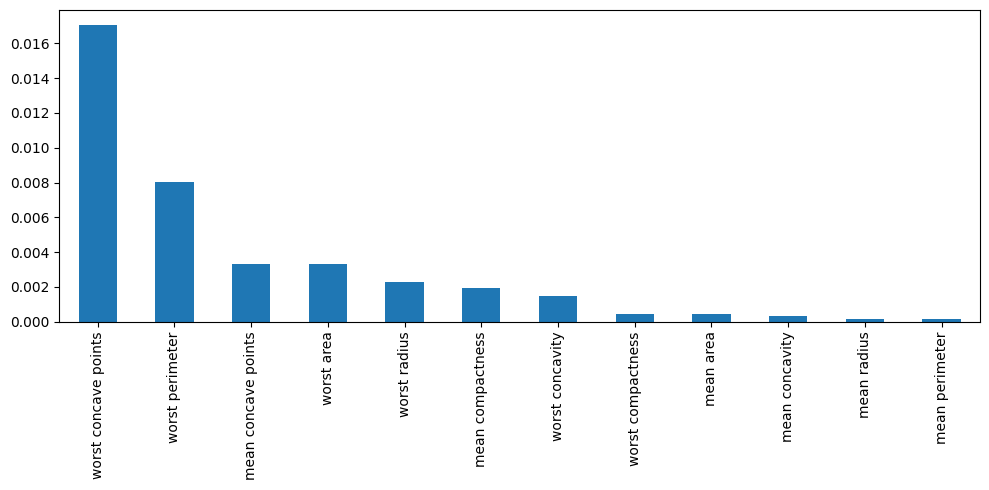

In [ ]:
from sklearn.inspection import permutation_importance
import pandas as pd
import matplotlib.pyplot as plt

hgb_model = gs_hgb.best_estimator_.named_steps['clf']
preproc = gs_hgb.best_estimator_.named_steps['pre']
X_trans = preproc.transform(Xbc)

try:
    selected_features
except:
    selector = preproc.named_steps['select']
    mask = selector.get_support()
    selected_features = Xbc.columns[mask]

r = permutation_importance(hgb_model, X_trans, ybc, n_repeats=20, random_state=42, n_jobs=-1, scoring='roc_auc')

imp_means = pd.Series(r.importances_mean, index=selected_features).sort_values(ascending=False)

print(imp_means.head(10))

plt.figure(figsize=(10,5))
imp_means.head(15).plot(kind='bar')
plt.tight_layout()
plt.savefig('img/bc_permutation_importance.png')
plt.show()


In [ ]:
joblib.dump(rs_xgb.best_estimator_, 'models/titanic_xgb.joblib')
joblib.dump(rs_rf.best_estimator_, 'models/titanic_rf.joblib')
joblib.dump(gs_hgb.best_estimator_, 'models/bc_hgb.joblib')

# salvar pequenas tabelas
pd.DataFrame(results).to_csv('img/titanic_results.csv', index=False)
print('Modelos e resultados salvos')

Modelos e resultados salvos
